# Notebook 1 - Data Wrangling

## 1. Intro & Problem identification

This project is based on a [Kaggle competition](https://www.kaggle.com/c/riiid-test-answer-prediction) that took place in the last 3 months of 2020. 

**Context**

Riiid Labs is an AI solutions provider delivering creative solutions to the education market that empowers global education players to rethink traditional ways of learning leveraging AI. In 2017 they created an AI tutor based on deep-learning algorithms that attracted more than one million South Korean students, and recently they released EdNet, the world’s largest open database for AI education, containing more than 100 million student interactions.

**Problem statement formation**

To create a personalized learning experience, Riiid Labs’s Tutor AI needs to accurately predict how students will perform on their next question. So the presented task was to come up with an accurate classification model to predict future students’ answer correctness, dependent on their past interactions.

[Kaggle Intro](https://www.kaggle.com/sohier/competition-api-detailed-introduction)

I need to set up the environment and use the **riideducation** Python module.

**not final - still need to describe how their testing was set up, and if I will use the same system of other**

## 2. Imports

In [1]:
#Importing the needed libraries

import os
import pandas as pd
import datatable as dt
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
style.use('fivethirtyeight')
from matplotlib.ticker import FuncFormatter

## 3. Data Collection

In [2]:
%%time

# To reduce loading time I am using datatable library for the train set

data = dt.fread("../data/raw/train.csv")
print("Train size:", data.shape)

Train size: (101230332, 10)
Wall time: 1min 4s


In [3]:
%%time

# reading the other 2 datasets: lectures and questions

lectures = pd.read_csv('../data/raw/lectures.csv')
questions = pd.read_csv('../data/raw/questions.csv')
print("Lectures size:", lectures.shape,'\nQuestions size:', questions.shape)

Lectures size: (418, 4) 
Questions size: (13523, 5)
Wall time: 512 ms


In [4]:
# Transfmoring the train set to pandas DF

train = data.to_pandas()

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int32  
 4   content_type_id                 bool   
 5   task_container_id               int32  
 6   user_answer                     int32  
 7   answered_correctly              int32  
 8   prior_question_elapsed_time     float64
 9   prior_question_had_explanation  object 
dtypes: bool(1), float64(1), int32(6), int64(1), object(1)
memory usage: 4.6+ GB


In [6]:
#changing some data type to minimize memory usage

train['content_id'] = train['content_id'].astype(np.int16)
train['task_container_id'] = train['task_container_id'].astype(np.int16)
train['user_answer'] = train['user_answer'].astype(np.int8)
train['answered_correctly'] = train['answered_correctly'].astype(np.int8)
train['prior_question_elapsed_time'] = train['prior_question_elapsed_time'].astype(np.float32)
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 bool   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  bool   
dtypes: bool(2), float32(1), int16(2), int32(2), int64(1), int8(2)
memory usage: 2.6 GB


In [7]:
# Checking memory usage from main DF

train.memory_usage(deep=True)

Index                                   128
row_id                            404921328
timestamp                         809842656
user_id                           404921328
content_id                        202460664
content_type_id                   101230332
task_container_id                 202460664
user_answer                       101230332
answered_correctly                101230332
prior_question_elapsed_time       404921328
prior_question_had_explanation    101230332
dtype: int64

## 4. Data Organization

For this project I'll be using the CookieCutter project organization, all uploaded to my Github repository.
I will submit a notebook for each of the steps in the Data Science Method:
1. Data Wrangling
2. EDA
3. Pre-processing and Training Data Development
4. Modeling

Other useful information can be found in the folowing folders in this repository: **data**, **models**, **reports** and **src**.


## 5. Data Definition

In the **Data Wrangling** and **EDA** steps we will be working with 3 datasets:

### 5.1 Train set

1. **Features**
    - **row_id**: (int64) ID code for the row.
    - **timestamp**: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
    - **user_id**: (int32) ID code for the user.
    - **content_id**: (int16) ID code for the user interaction
    - **content_type_id**: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
    - **task_container_id**: (int16) Id code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a task_container_id.
    - **user_answer**: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
    - **answered_correctly**: (int8) if the user responded correctly. Read -1 as null, for lectures.
    - **prior_question_elapsed_time**: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. Is null for a user's first question bundle or lecture. Note that the time is the average time a user took to solve each question in the previous bundle.
    - **prior_question_had_explanation**: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle, and is null for a user's first question bundle or lecture. Typically the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

In [8]:
train.describe()

,row_id,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time
count,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,1.012303e+08,9.887879e+07
mean,5.061517e+07,7.703644e+09,1.076732e+09,5.219605e+03,9.040624e+02,1.376123e+00,6.251644e-01,1.300508e+04
std,2.922268e+07,1.159266e+10,6.197163e+08,3.866359e+03,1.358302e+03,1.192896e+00,5.225307e-01,2.122839e+04
min,0.000000e+00,0.000000e+00,1.150000e+02,0.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00
25%,2.530758e+07,5.243436e+08,5.408116e+08,2.063000e+03,1.040000e+02,0.000000e+00,0.000000e+00,1.600000e+04
50%,5.061517e+07,2.674234e+09,1.071781e+09,5.026000e+03,3.820000e+02,1.000000e+00,1.000000e+00,2.100000e+04
75%,7.592275e+07,9.924551e+09,1.615742e+09,7.425000e+03,1.094000e+03,3.000000e+00,1.000000e+00,2.966600e+04
max,1.012303e+08,8.742577e+10,2.147483e+09,3.273600e+04,9.999000e+03,3.000000e+00,1.000000e+00,3.000000e+05


In [9]:
train.head(10)

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,True
1,1,56943,115,5716,False,2,2,1,37000.0,False
2,2,118363,115,128,False,0,0,1,55000.0,False
3,3,131167,115,7860,False,3,0,1,19000.0,False
4,4,137965,115,7922,False,4,1,1,11000.0,False
5,5,157063,115,156,False,5,2,1,5000.0,False
6,6,176092,115,51,False,6,0,1,17000.0,False
7,7,194190,115,50,False,7,3,1,17000.0,False
8,8,212463,115,7896,False,8,2,1,16000.0,False
9,9,230983,115,7863,False,9,0,1,16000.0,False


#### Let's explore these features

In [10]:
# Exploring User_id

print('Numer of unique users: ', train.user_id.nunique())

Numer of unique users:  393656


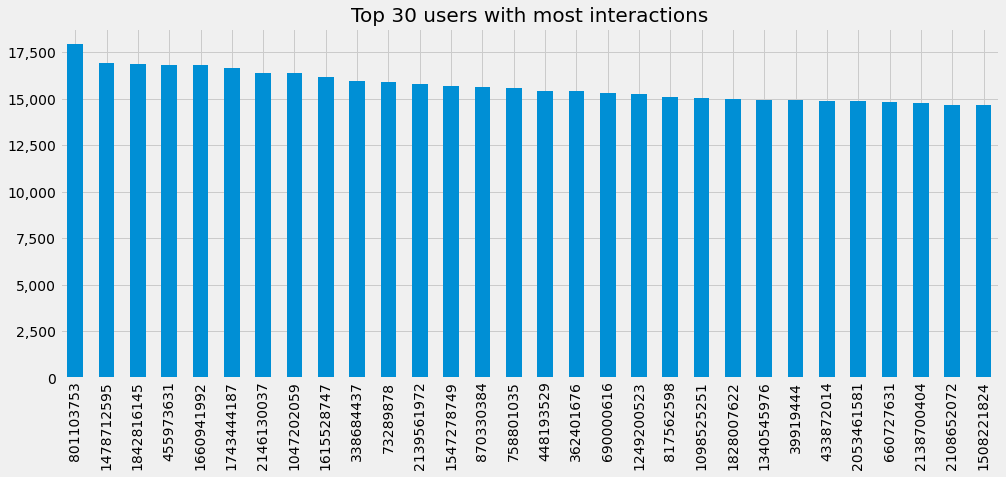

In [11]:
# Top 30 users with most interactions

int_series = train.user_id.value_counts()[:30]

fig = plt.figure(figsize=(15,6))
x = int_series.plot.bar()
plt.title("Top 30 users with most interactions", fontsize=20)
plt.xticks(rotation=90)
x.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ','))) #add thousands separator
plt.show()

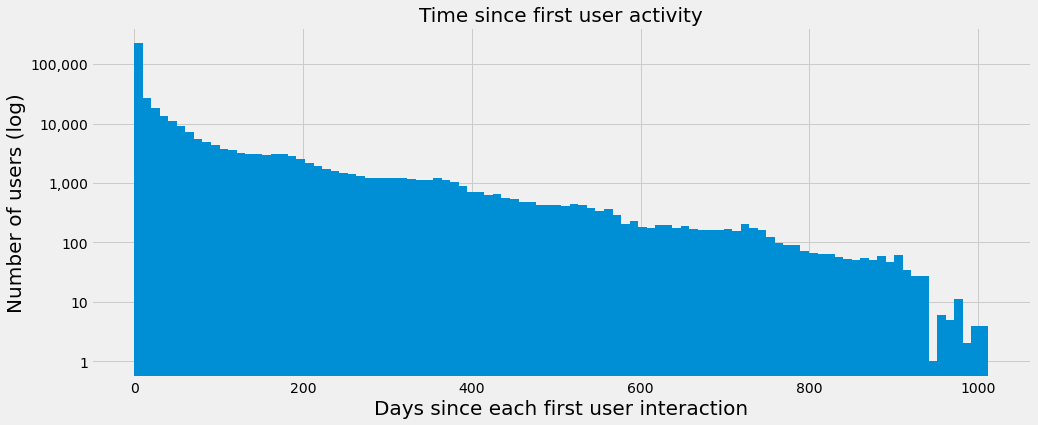

In [12]:
# Eploring the timestamp per user

max_timestamp = train[['user_id', 'timestamp']].groupby('user_id').max().timestamp/1000/60/60/24

fig = plt.figure(figsize=(15,6))
x = max_timestamp.plot.hist(bins = 100)
plt.title("Time since first user activity", fontsize=20)
plt.xlabel("Days since each first user interaction", fontsize=20)
plt.ylabel('Number of users (log)', fontsize=20)
plt.yscale('log')
x.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

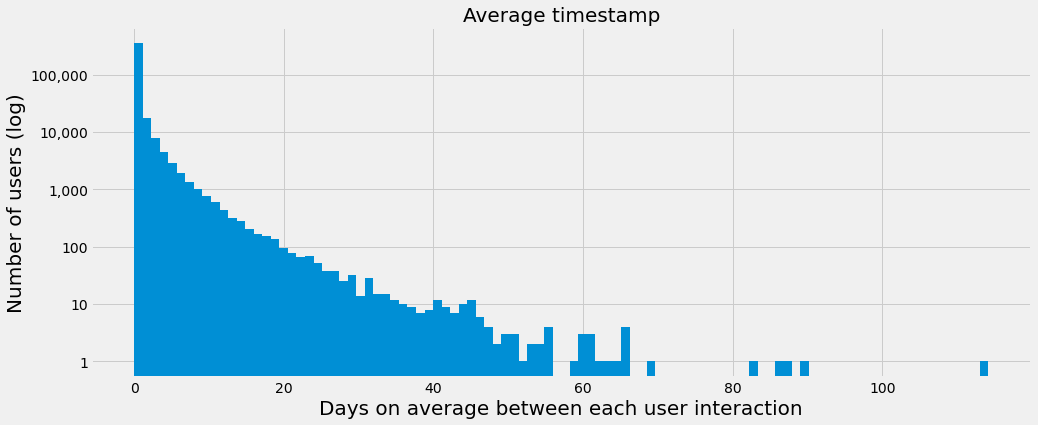

In [13]:
df = train[['user_id', 'timestamp']].groupby('user_id').agg(['max', 'count'])
df.columns = ['max', 'count']
avg_timestamp = df['max']/df['count']/1000/60/60/24

fig = plt.figure(figsize=(15,6))
x = avg_timestamp.plot.hist(bins = 100)
plt.title("Average timestamp", fontsize=20)
plt.xlabel("Days on average between each user interaction", fontsize=20)
plt.ylabel('Number of users (log)', fontsize=20)
plt.yscale('log')
x.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [14]:
#Exploring content_type_id

print('Numer of lectures interactions: ', train[train.content_type_id == True].content_type_id.count())
print('Numer of questions interactions: ', train[train.content_type_id == False].content_type_id.count())

Numer of lectures interactions:  1959032
Numer of questions interactions:  99271300


In [15]:
# Exploring content_id

print('Number of unique content_id: ', train.content_id.nunique())
print('Number of unique questions: ', train[train.content_type_id == False].content_id.nunique())
print('Number of unique lectures: ', train[train.content_type_id == True].content_id.nunique())

Number of unique content_id:  13782
Number of unique questions:  13523
Number of unique lectures:  415


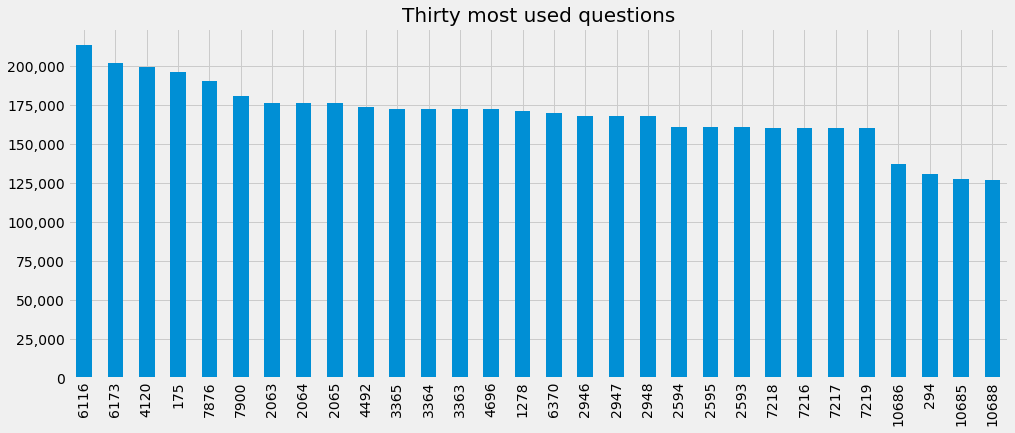

In [16]:
# 20 most used questions and 20 most used lectures

top30q = train[train.content_type_id == False].content_id.value_counts()[:30]
top30l = train[train.content_type_id == True].content_id.value_counts()[:30]

fig = plt.figure(figsize=(15,6))
ax = top30q.plot.bar()
plt.title("Thirty most used questions", fontsize=20)
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

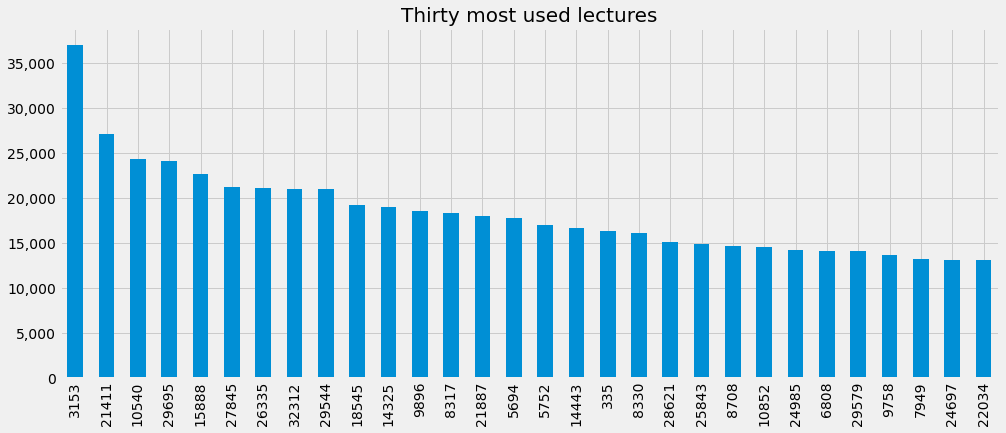

In [17]:
fig = plt.figure(figsize=(15,6))
ax = top30l.plot.bar()
plt.title("Thirty most used lectures", fontsize=20)
plt.xticks(rotation=90)
ax.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [18]:
# Exploring task container id: 
# Id code for the batch of questions or lectures. For example, a user might see three questions 
# in a row before seeing the explanations for any of them. Those three would all share a task_container_id.

print('Numer of uniques batches of questions or lectures: ', train.task_container_id.nunique())

Numer of uniques batches of questions or lectures:  10000


In [19]:
# Exploring user_answer.
# The questions are multiple choice (answers 0-3). 
# As mentioned in the data description, -1 is actually no-answer (as the interaction was a lecture instead of a question).

train.user_answer.value_counts()

 0    28186489
 1    26990007
 3    26084784
 2    18010020
-1     1959032
Name: user_answer, dtype: int64

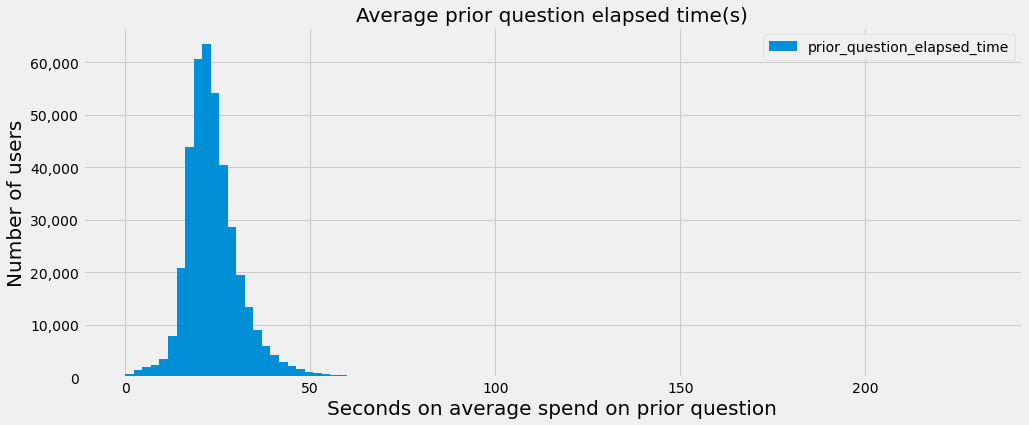

In [20]:
# Eploring the prior_question_elapsed_time

avg_elapsedtime = train[['user_id', 'prior_question_elapsed_time']].groupby('user_id').mean()/1000

x = avg_elapsedtime.plot.hist(bins = 100, figsize = (15,6))
plt.title("Average prior question elapsed time(s)", fontsize=20)
plt.xlabel("Seconds on average spend on prior question", fontsize=20)
plt.ylabel('Number of users', fontsize=20)
plt.xticks(rotation=0)

x.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

In [21]:
print('On average the users had a prior_question_elapsed_time of: ', avg_elapsedtime.prior_question_elapsed_time.mean(), 'seconds')

On average the users had a prior_question_elapsed_time of:  23.893590927124023 seconds


In [22]:
# Exploring prior_question_had_explanation.
# False content_type_id for Questions, True for Lectures

train.groupby('content_type_id').prior_question_had_explanation.value_counts()

content_type_id  prior_question_had_explanation
False            True                              90078066
                 False                              9193234
True             False                              1959032
Name: prior_question_had_explanation, dtype: int64

### 5.2 Exploring answered_correctly - the Target feature

**answer_correctly** is our target, and we have to predict to probability for an answer to be correct. Without looking at the lecture interactions (-1), we see about 2/3 of the questions were answered correctly.

Text(0.5, 1.0, 'Correct and wrong answers')

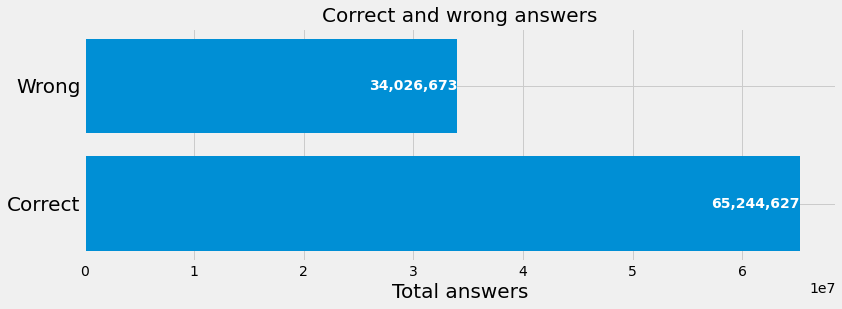

In [23]:
s = train[train.content_type_id == False].answered_correctly.value_counts()
s.index = ['Correct', 'Wrong']

plt.figure(figsize=(12,4))
plt.barh(s.index, s.values)
for i, v in zip(s.index, s.values):
    plt.text(v, i, '{:,}'.format(v), color='white', fontweight='bold', fontsize=14, ha='right', va='center')
plt.yticks(s.index, fontsize=20)

plt.xlabel('Total answers', fontsize=20)
plt.title('Correct and wrong answers', fontsize=20)

In [24]:
#For future exploration, we'll subset the questions from train set
train_q = train[train.content_type_id == False]


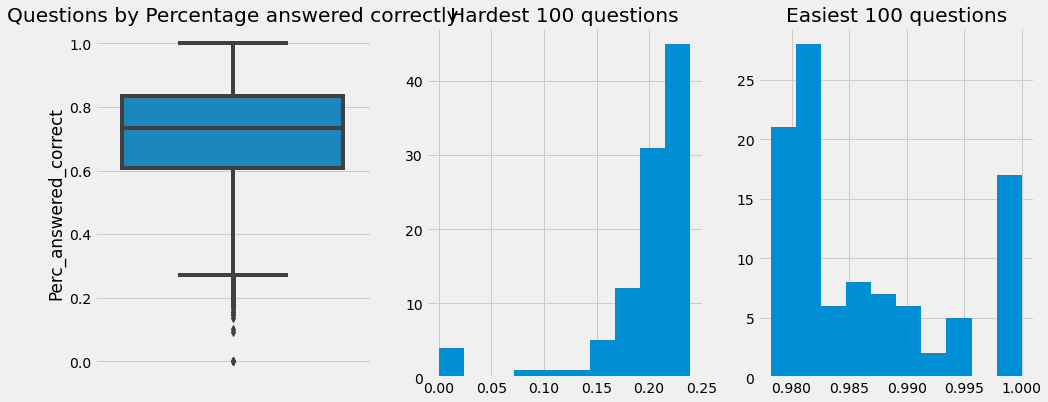

,Perc_answered_correct
count,13523.000000
mean,0.709460
std,0.164486
min,0.000000
25%,0.609345
50%,0.734215
75%,0.835116
max,1.000000


In [25]:
#Let's plot the whisker box for questions correctness and let's check how many questions are in the top and bottom 100
perc_ans_corr = train_q[['content_id', 'answered_correctly']].groupby('content_id').mean().sort_values(by = 'answered_correctly')
perc_ans_corr.columns = ['Perc_answered_correct']

fig, ax = plt.subplots(figsize=(15, 6))
plt.subplot(1,3,1)
sns.boxplot(y = 'Perc_answered_correct', data = perc_ans_corr)
plt.title('Questions by Percentage answered correctly')

plt.subplot(1,3,2)
plt.hist(perc_ans_corr.head(100))
plt.title('Hardest 100 questions')

plt.subplot(1,3,3)
plt.hist(perc_ans_corr.tail(100))
plt.title('Easiest 100 questions')

plt.show()
perc_ans_corr.describe()

We can see that overall the questions were answered correctly 70.9% times, and the 25% and 75% percentiles of our questions were answered correctly at 60.9% respectively 83.5%.

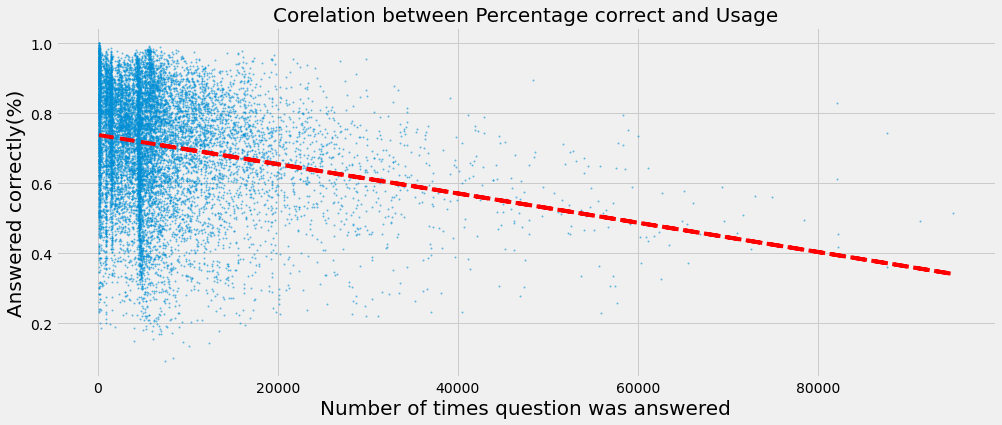

In [26]:
# Let's identify how difficult questions are, exploring the percentage of answered correctly versus question usage
perc_and_count = train_q[['content_id', 'answered_correctly']].groupby('content_id').agg(['mean', 'count'])
perc_and_count.columns = ['mean', 'count']
# Let's eliminate some outliers that might skew the polyfit
perc_and_count= perc_and_count[perc_and_count['count'].between(100, 100000)]

plt.figure(figsize=(15,6))
plt.scatter(perc_and_count['count'] , perc_and_count['mean'], s = 2, alpha = 0.5)
plt.title("Corelation between Percentage correct and Usage", fontsize=20)
plt.xlabel("Number of times question was answered", fontsize=20)
plt.ylabel('Answered correctly(%)', fontsize=20)
z = np.polyfit(perc_and_count['count'],perc_and_count['mean'], 1)
p = np.poly1d(z)
plt.plot(perc_and_count['count'],p(perc_and_count['count']),"r--")

It seems that the questions that are answered a few times tend to be the easier ones, while the ones that are most common in tests tend to be the more difficult ones.

In [27]:
# Let's explore the 30 Hardest, 30 Easiest, Top 30 popular questions (from the questions used at least 1000 times)

s = train_q[['content_id', 'answered_correctly']].groupby('content_id').agg(['mean', 'count'])
s.columns = ['mean', 'count']
s = s[s['count'] >=1000]
s_hardest = s.sort_values('mean').head(30)
s_easiest = s.sort_values('mean', ascending = False).head(30)
s_popular = s.sort_values('count', ascending = False).head(30)

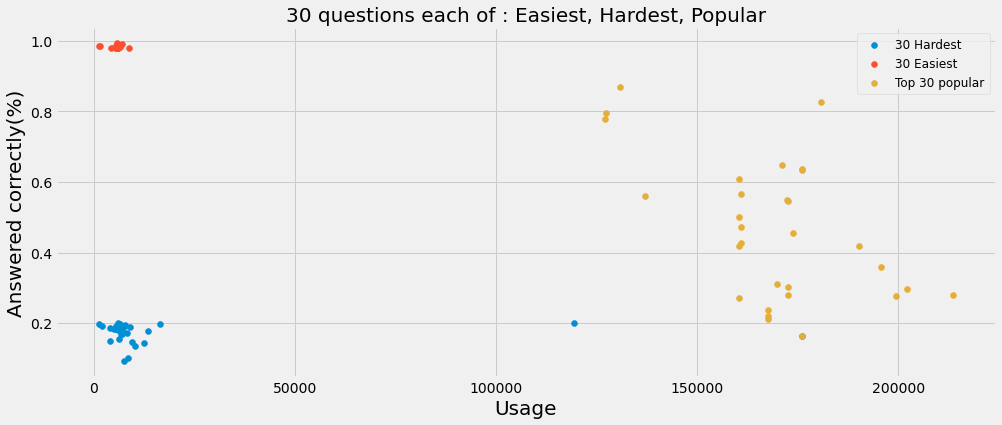

In [28]:
plt.figure(figsize=(15,6))
plt.scatter(s_hardest['count'], s_hardest['mean'],)
plt.scatter(s_easiest['count'], s_easiest['mean'])
plt.scatter(s_popular['count'], s_popular['mean'])

plt.title("30 questions each of : Easiest, Hardest, Popular", fontsize=20)
plt.xlabel("Usage", fontsize=20)
plt.ylabel('Answered correctly(%)', fontsize=20)
plt.legend(['30 Hardest', '30 Easiest', 'Top 30 popular'], fontsize=12, loc="upper right", frameon = True)

### 5.3 Questions Set

**1.Features**

- **question_id**: foreign key for the train/test content_id column, when the content type is question (0).

- **bundle_id**: code for which questions are served together.

- **correct_answer**: the answer to the question. Can be compared with the train user_answer column to check if the user was right.

- **part**: the relevant section of the TOEIC test.

- **tags** : one or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

To understand better where the questions and lectures are comming from, let's analyze a bit the format of the TOEIC test and the parts it contains. The TOEIC L&R has 200 questions to answer in two hours in **Listening** (approximately 45 minutes, 100 questions) and **Reading** (75 minutes, 100 questions), organized as follows:

Listening section:
- Part1 - Photographs: 6 questions
- Part2 - Question-Response: 25 questions
- Part3 - Conversations: 39 questions
- Part4 - Talks: 30 questions

Reading section:
- Part5 - Incomplete Sentences: 30 questions
- Part6 - Text Completion: 16 questions
- Part7 - Single Passages: 29 questions & Multiple Passages: 25 questions

In [29]:
print("\n Questions dataset")
questions.info()


 Questions dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [30]:
questions.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


In [31]:
questions.head(10)

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38
5,5,5,2,1,131 149 162 81
6,6,6,2,1,10 94 162 92
7,7,7,0,1,61 110 162 29
8,8,8,3,1,131 13 162 92
9,9,9,3,1,10 164 81


In [32]:
#Let's see what is the missing value from tags
questions[questions.tags.isnull()]

,question_id,bundle_id,correct_answer,part,tags
10033,10033,10033,2,6,NaN


In [33]:
#Lets transformthe tags into a list of tags
questions['tags'] = questions['tags'].astype(str)
tags_list = [x.split() for x in questions.tags.values]
questions['tags'] = tags_list
questions

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,"[51, 131, 162, 38]"
1,1,1,1,1,"[131, 36, 81]"
2,2,2,0,1,"[131, 101, 162, 92]"
3,3,3,0,1,"[131, 149, 162, 29]"
4,4,4,3,1,"[131, 5, 162, 38]"
...,...,...,...,...,...
13518,13518,13518,3,5,[14]
13519,13519,13519,3,5,[8]
13520,13520,13520,2,5,[73]
13521,13521,13521,0,5,[125]


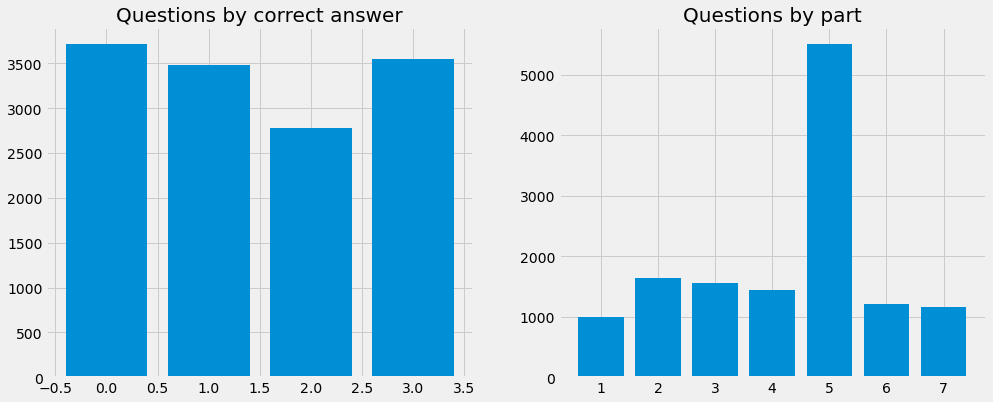

In [34]:
#Let's explore how many questions per correct_answer and per part
per_correct_ans = questions.groupby(by = 'correct_answer').agg({'question_id' : 'count'})
per_part = questions.groupby(by = 'part').agg({'question_id' : 'count'})

fig, ax = plt.subplots(figsize=(15, 6))
plt.subplot(1,2,1)
plt.bar(per_correct_ans.index, per_correct_ans.question_id)
plt.title("Questions by correct answer", fontsize=20)
plt.subplot(1,2,2)
plt.bar(per_part.index, per_part.question_id)
plt.title("Questions by part", fontsize=20)
plt.show()

We can see that the total questions by correct answer are around the same values.
The questions by part reveals that there is a considerable higher number of questions for **part 5** compared to the other 6 parts.

In [35]:
#Let's see how many tags we have
tags = [item for elem in tags_list for item in elem if str(item) != 'nan']
tags = set(tags)
tags = list(tags)

print('There are ', len(tags), 'different questions tags')


There are  188 different questions tags


In [36]:
# Let's merge perc_and_count to our questions dataset 
questions_improved = questions.merge(perc_and_count, left_on = "question_id", right_on = "content_id", how = "left")

questions_improved

,question_id,bundle_id,correct_answer,part,tags,mean,count
0,0,0,0,1,"[51, 131, 162, 38]",0.907721,6903.0
1,1,1,1,1,"[131, 36, 81]",0.890646,7398.0
2,2,2,0,1,"[131, 101, 162, 92]",0.554281,44905.0
3,3,3,0,1,"[131, 149, 162, 29]",0.779437,22973.0
4,4,4,3,1,"[131, 5, 162, 38]",0.613215,31736.0
...,...,...,...,...,...,...,...
13518,13518,13518,3,5,[14],0.786866,868.0
13519,13519,13519,3,5,[8],0.571429,924.0
13520,13520,13520,2,5,[73],0.672474,861.0
13521,13521,13521,0,5,[125],0.808046,870.0


In [37]:
questions_improved['right'] = questions_improved['mean']*questions_improved['count']
questions_improved

,question_id,bundle_id,correct_answer,part,tags,mean,count,right
0,0,0,0,1,"[51, 131, 162, 38]",0.907721,6903.0,6266.0
1,1,1,1,1,"[131, 36, 81]",0.890646,7398.0,6589.0
2,2,2,0,1,"[131, 101, 162, 92]",0.554281,44905.0,24890.0
3,3,3,0,1,"[131, 149, 162, 29]",0.779437,22973.0,17906.0
4,4,4,3,1,"[131, 5, 162, 38]",0.613215,31736.0,19461.0
...,...,...,...,...,...,...,...,...
13518,13518,13518,3,5,[14],0.786866,868.0,683.0
13519,13519,13519,3,5,[8],0.571429,924.0,528.0
13520,13520,13520,2,5,[73],0.672474,861.0,579.0
13521,13521,13521,0,5,[125],0.808046,870.0,703.0


In [38]:
# Let's explore the percentage of questions right per part as well as total questions used per part

q_summary = questions_improved.groupby('part').sum()
q_summary['average'] = q_summary['right']/q_summary['count']
q_summary = q_summary.drop(labels = ['question_id', 'bundle_id', 'correct_answer', 'mean'], axis= 'columns')
q_summary

,count,right,average
part,,,
1,6887681.0,5254396.0,0.762869
2,17798842.0,12565477.0,0.705972
3,8110267.0,5807012.0,0.716008
4,6557077.0,4542115.0,0.692704
5,39654120.0,24530083.0,0.618601
6,10073142.0,6834029.0,0.678441
7,4312221.0,2978552.0,0.690723


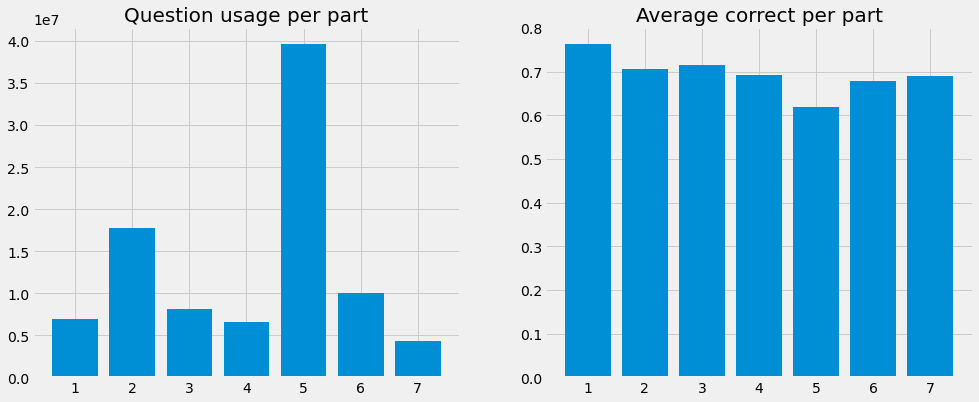

In [39]:
fig, ax = plt.subplots(figsize=(15, 6))
plt.subplot(1,2,1)
plt.bar(q_summary.index, q_summary['count'])
plt.title("Question usage per part", fontsize=20)
plt.subplot(1,2,2)
plt.bar(q_summary.index, q_summary['average'])
plt.title("Average correct per part", fontsize=20)
plt.show()

We see that part 5 has the biggest usage, and that this part seems to be the most difficult one as well, with only 61.8% questions answered correctly.


In [40]:
# Finnaly, let's explore the usage and difficulty of tags

tags_df = pd.DataFrame()

for i in range(len(tags)):
    main_df = questions_improved[questions_improved.tags.apply(lambda t: tags[i] in t)]
    df_agg = main_df.agg({'right':['sum'], 'count':['sum']})
    df_agg['Total_questions'] = df_agg['count']
    df_agg['Percent_correct'] = df_agg.right/df_agg.Total_questions
    df_agg['Different_questions_having_this_tag'] = len(main_df)
    df_agg = df_agg.drop('count', axis = 1)
    df_agg['tag'] = tags[i]
    df_agg = df_agg.set_index('tag')
    tags_df = tags_df.append(df_agg)

tags_df.reset_index(inplace = True)
tags_df[['tag', 'right', 'Total_questions']] = tags_df[['tag','right', 'Total_questions']].astype(int)
tags_df = tags_df.sort_values(by = 'tag')
tags_df

,tag,right,Total_questions,Percent_correct,Different_questions_having_this_tag
32,0,204656,326679,0.626474,49
112,1,1465625,2409509,0.608267,422
173,2,1206072,1727202,0.698281,144
122,3,187107,290278,0.644579,45
133,4,320363,499255,0.641682,50
...,...,...,...,...,...
147,183,130338,190269,0.685020,15
17,184,201355,287908,0.699373,96
169,185,139311,192498,0.723701,15
163,186,5055,9002,0.561542,3


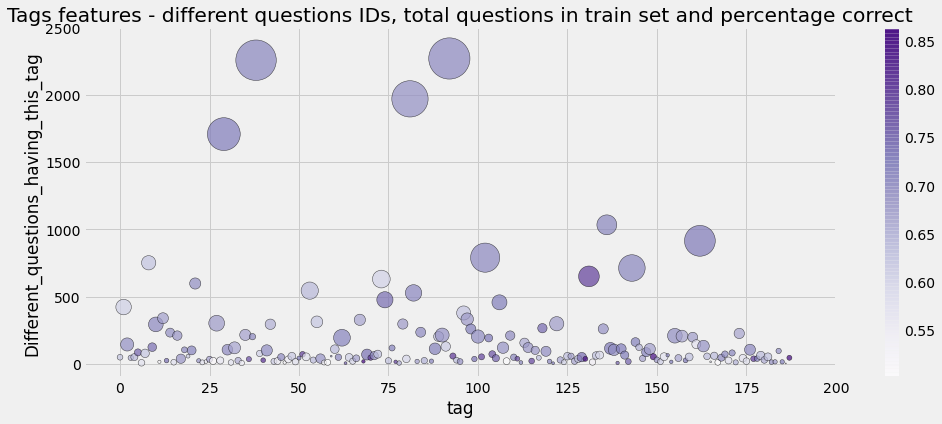

In [41]:
# Plotting the tags features - different questions with the tag, total questions in train set and percentage correct
area = tags_df.Total_questions*1e-4
color = tags_df.Percent_correct
tags_df.plot.scatter('tag', 'Different_questions_having_this_tag' ,
                     c = color, colormap=matplotlib.cm.get_cmap('Purples'),
                     s = area, edgecolors = 'k',
                     sharex=False, figsize = (15,6), alpha = 0.7)
plt.title('Tags features - different questions IDs, total questions in train set and percentage correct')
plt.axis(xmin = -10, xmax = 200, ymin = -100, ymax = 2500)
plt.show()

### 5.4 Lectures Set

**1.Features**

- **lecture_id**: foreign key for the train/test content_id column, when the content type is lecture (1).

- **part**: top level category code for the lecture.

- **tag**: one tag codes for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.

- **type_of**: brief description of the core purpose of the lecture

In [42]:
print("\n Lectures dataset")
lectures.info()


 Lectures dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [43]:
lectures.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [44]:
lectures.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [45]:
#Lectures by part and type_of lecture

sub_lectures = lectures.groupby(['part', 'type_of']).count()
sub_lectures = sub_lectures.drop(['tag'], axis = 1)
sub_lectures = sub_lectures.rename({'lecture_id':'Lectures'}, axis = 1)

sub_lectures.T

part           1                        2                                  3  \
type_of  concept solving question concept intention solving question concept   
Lectures      20               34      18         7               31       7   

part                            4                        5                   \
type_of  solving question concept solving question concept solving question   
Lectures               12      19               12      72               69   

part                   6                                7                   
type_of  starter concept solving question starter concept solving question  
Lectures       2      63               19       1      23                9

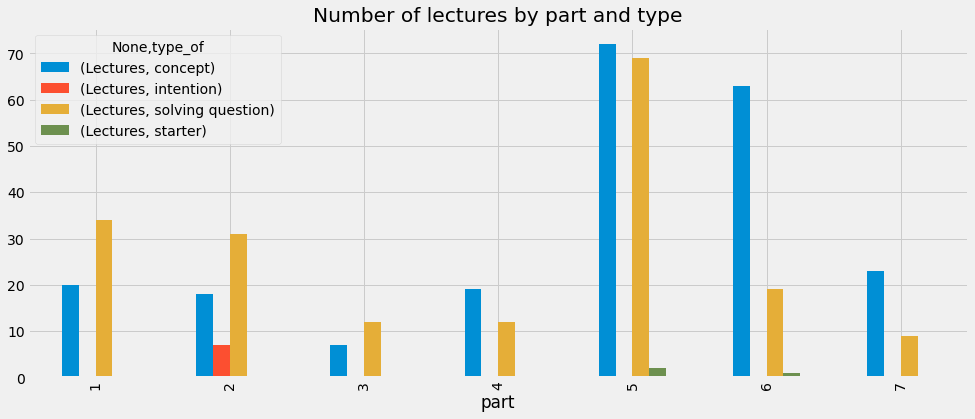

In [46]:
sub_lectures.unstack().plot(kind = 'bar', figsize = (15,6))
plt.title('Number of lectures by part and type')
plt.show()

## 6. Data Cleaning

### 6.1 Data cleaning train set

In [47]:
#Calculating the percentage of missing values per feature from train set
missing = pd.concat([train.isnull().sum(), 100 * train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
row_id,0,0.000000
timestamp,0,0.000000
user_id,0,0.000000
content_id,0,0.000000
content_type_id,0,0.000000
task_container_id,0,0.000000
user_answer,0,0.000000
answered_correctly,0,0.000000
prior_question_had_explanation,0,0.000000
prior_question_elapsed_time,2351538,2.322958


We have 2,351,538 observations without prior_question_elapsed_time.

In [48]:
missing_values = train[train.prior_question_elapsed_time.isnull()]
missing_values

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,0,115,5692,False,1,3,1,NaN,True
46,46,0,124,7900,False,0,0,1,NaN,True
76,76,0,2746,5273,False,0,1,0,NaN,True
89,89,653762,2746,6808,True,14,-1,-1,NaN,False
96,96,0,5382,5000,False,0,0,1,NaN,True
...,...,...,...,...,...,...,...,...,...,...
101230195,101230195,1073593458,2147482216,21887,True,170,-1,-1,NaN,False
101230218,101230218,1240316256,2147482216,6808,True,193,-1,-1,NaN,False
101230220,101230220,1240470616,2147482216,27699,True,195,-1,-1,NaN,False
101230222,101230222,1240524060,2147482216,5752,True,197,-1,-1,NaN,False


We can see we have a NaN values for prior_question_elapsed_time where the timestamp is **0** which makes sense, since there is no prior elapsed time for each student's first interaction.

Lets explore the rest of the missing values.

In [49]:
missing_values = missing_values[(missing_values.timestamp != 0)]
# Content of type True (Lecture) should also generate NaNs for prior_question_elapsed_time
missing_values['content_type_id'].value_counts()

True     1958952
False         65
Name: content_type_id, dtype: int64

In [50]:
missing_values = missing_values[missing_values['content_type_id'] == False]
missing_values

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1631931,1631931,12231,34683777,4784,False,1,1,1,NaN,True
7791632,7791632,10632,169503292,6120,False,1,1,1,NaN,True
8131664,8131664,160173,177104356,4818,False,1,1,1,NaN,True
9604622,9604622,73906,209367010,4533,False,2,0,1,NaN,True
11238194,11238194,97682,243667830,8643,False,1,3,1,NaN,True
...,...,...,...,...,...,...,...,...,...,...
95632769,95632769,47790,2028759377,660,False,2,3,1,NaN,True
96254976,96254976,24675,2042472960,4305,False,2,1,0,NaN,True
97291668,97291668,33210,2064612791,6340,False,3,1,1,NaN,True
97835717,97835717,274233,2075925203,4189,False,0,3,0,NaN,True


We have 65 observations that are questions and are not the first user interaction. 

To sumarize there are 3 types of missing values for out Prior Elapsed Time feature:
* the 'timestamp == 0' ones coresponding to the student's firts interaction with the software --> we will replace the **prior_question_elapsed_time** with 0
* the 'content_type_id == False' ones, denoting lectures --> we will save this interactions in a new DataFrame and we will drop them from train.
    That is in addition to another aspect of the lectures records, the fact that they don't have a relevant information for **answered_correctly**, our target.
* a number of 65 where the data is missing --> we will drop these


In [51]:
# Step 1 - replace the NaNs coresponding to user's first interactions with 0
cond1 = train['timestamp'] == 0
cond2 = train.prior_question_elapsed_time.isnull()

train.loc[(cond1 & cond2), 'prior_question_elapsed_time'] = 0

In [67]:
# Step 2 is to save the records from lectures to another DataFrame
 
lecture_records = train[train.content_type_id == True]

In [68]:
# Now let's drop the irelevant features from this DataFrame
lecture_records = lecture_records.drop(labels = ['user_answer', 'answered_correctly', 'content_type_id', 'prior_question_elapsed_time', 'prior_question_had_explanation'], axis = 'columns')
lecture_records.head(10)

,row_id,timestamp,user_id,content_id,task_container_id
89,89,653762,2746,6808,14
117,117,10183847,5382,16736,21
212,212,1424348597,5382,30207,104
216,216,1425557777,5382,18545,121
295,295,405813029,8623,10540,59
302,302,406265768,8623,25843,66
323,323,577424049,8623,29544,87
409,409,3083871588,12741,20307,33
441,441,3263276452,12741,10688,53
486,486,3268387671,12741,10217,66


In [69]:
# Step 3 is to drop all lectures interactions from the train set
train = train[train.content_type_id == False]
print("Train size:", train.shape)

Train size: (99271300, 10)


In [70]:
# Let's check if we have any missing values in our train

missing = pd.concat([train.isnull().sum(), 100 * train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing

,count,%
row_id,0,0.000000
timestamp,0,0.000000
user_id,0,0.000000
content_id,0,0.000000
content_type_id,0,0.000000
task_container_id,0,0.000000
user_answer,0,0.000000
answered_correctly,0,0.000000
prior_question_elapsed_time,65,0.000065
prior_question_had_explanation,0,0.000000


In [71]:
# let's drop the 65 remaining records containing missing values
train.dropna(axis = 0, how = 'any', inplace=True)

In [72]:
# Let's check if we have any missing values in our train

missing = pd.concat([train.isnull().sum(), 100 * train.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing

,count,%
row_id,0,0.0
timestamp,0,0.0
user_id,0,0.0
content_id,0,0.0
content_type_id,0,0.0
task_container_id,0,0.0
user_answer,0,0.0
answered_correctly,0,0.0
prior_question_elapsed_time,0,0.0
prior_question_had_explanation,0,0.0


In [73]:
# Let's check if we have any missing values in our lecture_records
missing = pd.concat([lecture_records.isnull().sum(), 100 * lecture_records.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
row_id,0,0.0
timestamp,0,0.0
user_id,0,0.0
content_id,0,0.0
task_container_id,0,0.0


### 6.2 Data cleaning Questions and Lectures

In [74]:
# Calculating the percentage of missing values per feature from questions set
missing = pd.concat([questions.isnull().sum(), 100 * questions.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count')

,count,%
question_id,0,0.0
bundle_id,0,0.0
correct_answer,0,0.0
part,0,0.0
tags,0,0.0


There is one question that has no tag and we identified it in the exploratory part of the notebook. That was question 10033.
Besides that we dont have any other missing values

In [75]:
# For question 10033, let's see how many observations we have with this content_id in our train set
train[train.content_id == 10033]

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
62750278,62750278,1286282597,1333688829,10033,False,1127,2,1,35000.0,True


There is only one interaction of a student with the 10033 question that has no tags. We can drop that observation from our train set

In [76]:
train = train[train.content_id != 10033]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99271234 entries, 0 to 101230331
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int32  
 1   timestamp                       int64  
 2   user_id                         int32  
 3   content_id                      int16  
 4   content_type_id                 bool   
 5   task_container_id               int16  
 6   user_answer                     int8   
 7   answered_correctly              int8   
 8   prior_question_elapsed_time     float32
 9   prior_question_had_explanation  bool   
dtypes: bool(2), float32(1), int16(2), int32(2), int64(1), int8(2)
memory usage: 3.3 GB


In [77]:
# And we can drop it from the questions set as well
questions = questions[questions.question_id != 10033]

In the lecture set there is no missing value, so we have completed our data cleaning

## 7. Saving Data

In [78]:
train.to_csv('../data/interim/train_cleaned.csv')
lecture_records.to_csv('../data/interim/lecture_records.csv')
questions.to_csv('../data/interim/questions_c.csv')
lectures.to_csv('../data/interim/lectures_c.csv')

## 8. Summary


I started this challenge using 3 datasets in our effort to predict if users' next interaction will be correct or not.

The first one is the train set containing all the interactions users had with the software. These were either answering questions or waching lectures. We have exlored the features from this set and here are some of the findings:
* the set contains a large amount of records: **101,230,332** (almost 2M lectures and 99M questions) , coming from **393,656 users**
* most users are having the average timestamp between their records within one day, resulting they are pretty active
* we have aexactly 10,000 batches containers with questions and lectures, **415 distinct lectures** and **13523 distinct questions**
* users spend on average 23.89 seconds on answering questions, with ranges between a few seconds up to around 1 minute.

The Target feature is **answered_correctly**. This is what I found out about this feature from our initial feature EDA:
* questions were answered correctly 70.9% times, and the 25% and 75% percentiles of our questions were answered correctly at 60.9% respectively 83.5%
* we noticed that the correlation between percentage correct and total usage of questions is negative, so it seems that the questions that are answered a few times tend to be the easier ones, while the ones that are most common in tests tend to be the more difficult ones.

For the second set I used, the questions set, I first explored the 7 part of the TOEIC test. Then I modified the tags from object type to a list of strings. We also aobserved:
* questions from part 5 are a lot more than for the other 6 parts, and they also see to be the hardest having the least percentage correct per parts
* exploring the tags we see that there are a few that are very common, in more than 1500 questions, and tha majority are found in up to 500 questions.

Exploring the lectures we can see that part 5 has again the most lectures compared to the other 6 parts.

I finished this notebook by cleaning the missing data and dividing the train set into **train(containing just the questions interactions)** and **lecture_records** and saving the data.
